In [7]:
import sys
import anomaly_detection_models
from anomaly_detection_models import SALAD, DataVsSim, CWoLa, SACWoLa

sys.path.append('../../ATLAS_anomaly_detection/.')
sys.path.append('../../ATLAS_anomaly_detection/decorrelation/.')
from utils import load_LHCO
from helpers import add_vars

import matplotlib.pyplot as plt
import numpy as np
import pandas as pdb
import keras

## load test dataset

here we use LHCO dataset, and cheat by calling some locally defined commands to load it. 

In [2]:
lhco = load_LHCO()
data, sim, signal = add_vars(lhco['pythia_qcd']), add_vars(lhco['herwig_qcd']), add_vars(lhco['wprime'])

## load data

the best way to do this is to specify a training and testing version of the features, signal tags, simulation vs data tags, and sb tags.

In [8]:
from sklearn.model_selection import train_test_split
from keras.backend import clear_session
from importlib import reload
import anomaly_detection_models
reload(anomaly_detection_models)
from anomaly_detection_models import SALAD, DataVsSim, CWoLa, SACWoLa


n_signal = 1500
cols = ['mJJ', 'maxmass', 'minmass', 'tau21a', 'tau21b']

test_frac = 0.5

x_data,x_data_test,x_sim,x_sim_test = train_test_split(data.loc[:,cols].values, sim.loc[:,cols].values, test_size=test_frac) 

signal_idx = np.random.choice(len(signal), n_signal, replace=False)

x = np.concatenate([x_data, x_sim, signal.loc[:,cols].iloc[signal_idx].values])
x[:,:3]/=1000
y_signal = np.concatenate([np.zeros(len(x_data)), np.zeros(len(x_sim)), np.ones(len(signal_idx))])
y_sim = np.concatenate([np.ones(len(x_data)), np.zeros(len(x_sim)), np.ones(len(signal_idx))])
y_sr = ((x[:,0] <= 3.7) & (x[:,0] >= 3.3))
y_sb = ((x[:,0] > 3.0) & (x[:,0] < 3.3)) | ((x[:,0] > 3.7) & (x[:,0] < 4.0))

x_test = np.concatenate([x_data_test, x_sim_test, np.delete(signal.loc[:,cols].values, signal_idx, axis=0)])
x_test[:,:3]/=1000
y_sr_test = ((x_test[:,0] <= 3.7) & (x_test[:,0] >= 3.3))
y_sb_test = ((x_test[:,0] > 3.0) & (x_test[:,0] < 3.3)) | ((x_test[:,0] > 3.7) & (x_test[:,0] < 4.0))
y_signal_test = np.concatenate([np.zeros(len(x_data_test)), np.zeros(len(x_sim_test)), np.ones(len(signal) - len(signal_idx))])
y_sim_test = np.concatenate([np.ones(len(x_data_test)), np.zeros(len(x_sim_test)), np.ones(len(signal) - len(signal_idx))])

print(((y_signal==1)&(y_sim==1)&(y_sr==1)).sum()/np.sqrt(((y_signal==0)&(y_sim==1)&(y_sr==1)).sum()))

4.5665720237690675


### create architectures

you can also pass finished models

In [21]:
def dctr_model():
    sb_model = keras.models.Sequential()
    sb_model.add(keras.layers.Dense(64, input_shape=(5,), activation='relu'))
    sb_model.add(keras.layers.Dense(64, activation='relu'))
    sb_model.add(keras.layers.Dense(64, activation='relu'))
    sb_model.add(keras.layers.Dense(1, activation='sigmoid'))
    return sb_model

def base_model():
    base_model = keras.models.Sequential()
    base_model.add(keras.layers.Dense(64, input_shape=(4,), activation='relu'))
    base_model.add(keras.layers.Dense(64, activation='relu'))
    base_model.add(keras.layers.Dense(64, activation='relu'))
    base_model.add(keras.layers.Dense(1, activation='sigmoid'))
    return base_model

In [23]:
# from importlib import reload
# import models
# reload(models)
# from models import *
from keras.backend import clear_session
from importlib import reload
import anomaly_detection_models
reload(anomaly_detection_models)
from anomaly_detection_models import SALAD, DataVsSim, CWoLa, SACWoLa

global_params = {
    'epochs': 1,
    'verbose': 1,
    'batch_size': 200,
    'compile': True
}
clear_session()
models = {    
    'salad': SALAD(**global_params, model=base_model(), sb_model=dctr_model(), sb_epochs=1, sb_batch_size=200,),
    'dvsim': DataVsSim(**global_params, model=base_model(), ),
    'cwola': CWoLa(**global_params, model=base_model(), ),
    'sacwola': SACWoLa(**global_params, model=base_model(), lambda_=1.0)
}
preds = {} 
for name,m in models.items():
    print('training ', name)
    m.fit(x[:,1:][y_sr | y_sb], y_sim=y_sim[y_sr | y_sb], y_sr=y_sr[y_sr | y_sb], m=x[:,0:1][y_sr | y_sb])
    m.save('data/test/{}'.format(name))
    preds[name] = m.predict(x_test[y_sr_test,1:])
#     clear_session()

training  salad
Epoch 1/1
202409/202409 [==============================] - 5s 26us/step - loss: 0.6858
Epoch 1/1
123173/123173 [==============================] - 3s 26us/step - loss: 0.6448
training  dvsim
Epoch 1/1
123173/123173 [==============================] - 3s 26us/step - loss: 0.6870
training  cwola
Epoch 1/1
162776/162776 [==============================] - 4s 26us/step - loss: 0.6649
training  sacwola
Epoch 1/1
325582/325582 [==============================] - 8s 24us/step - loss: 0.6928


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


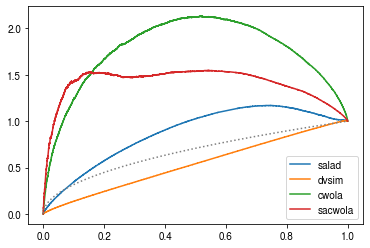

In [24]:
from sklearn.metrics import roc_curve

for name in models.keys():
    fpr,tpr,thresh = roc_curve(y_signal_test[y_sr_test], preds[name])
    plt.plot(tpr, tpr/np.sqrt(fpr), label=name)
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':', color='tab:grey')
plt.legend()
plt.show()

In [27]:
# from importlib import reload
# import models
# reload(models)
# from models import *
from keras.backend import clear_session
from importlib import reload
import anomaly_detection_models
reload(anomaly_detection_models)
from anomaly_detection_models import SALAD, DataVsSim, CWoLa, SACWoLa

global_params = {
    'epochs': 10,
    'verbose': 1,
    'batch_size': 200,
    'compile': True
}
clear_session()
models = {
    'salad': SALAD(**global_params, model=base_model(), sb_model=dctr_model(), sb_epochs=10, sb_batch_size=200,),
    'dvsim': DataVsSim(**global_params, model=base_model(), ),
    'cwola': CWoLa(**global_params, model=base_model(), ),
    'sacwola': SACWoLa(**global_params, model=base_model(), lambda_=1.0)
}
preds = {} 
for name,m in models.items():
    print('training ', name)
    m.fit(x[:,1:][y_sr | y_sb], y_sim=y_sim[y_sr | y_sb], y_sr=y_sr[y_sr | y_sb], m=x[:,0:1][y_sr | y_sb])
    m.save('data/test10/{}'.format(name))
    preds[name] = m.predict(x_test[y_sr_test,1:])
#     clear_session()

training  salad
Epoch 1/10
202409/202409 [==============================] - 5s 25us/step - loss: 0.6865
Epoch 2/10
202409/202409 [==============================] - 5s 23us/step - loss: 0.6841
Epoch 3/10
202409/202409 [==============================] - 5s 22us/step - loss: 0.6835
Epoch 4/10
202409/202409 [==============================] - 5s 23us/step - loss: 0.6829
Epoch 5/10
202409/202409 [==============================] - 5s 22us/step - loss: 0.6827
Epoch 6/10
202409/202409 [==============================] - 5s 22us/step - loss: 0.6822
Epoch 7/10
202409/202409 [==============================] - 5s 22us/step - loss: 0.6819
Epoch 8/10
202409/202409 [==============================] - 5s 23us/step - loss: 0.6817
Epoch 9/10
202409/202409 [==============================] - 5s 23us/step - loss: 0.6814
Epoch 10/10
202409/202409 [==============================] - 5s 23us/step - loss: 0.6812
Epoch 1/10
123173/123173 [==============================] - 3s 27us/step - loss: 0.6840
Epoch 2/10
1231

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


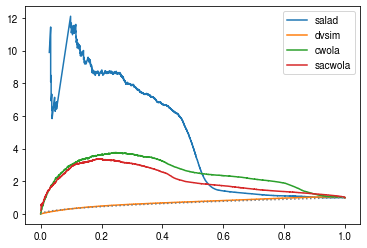

In [39]:
from sklearn.metrics import roc_curve

for name,m in models.items():
    yhat = m.predict(x_test[y_sr_test,1:])
    fpr,tpr,thresh = roc_curve(y_signal_test[y_sr_test], yhat)
    plt.plot(tpr, tpr/np.sqrt(fpr), label=name)
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':', color='tab:grey')
plt.legend()
plt.show()

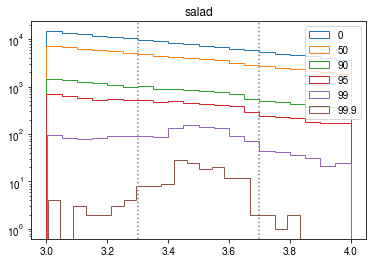

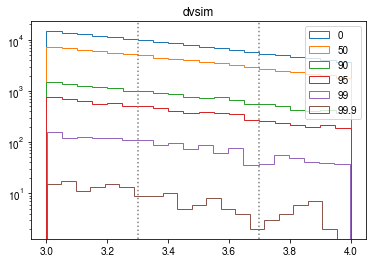

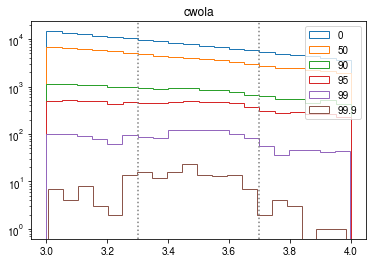

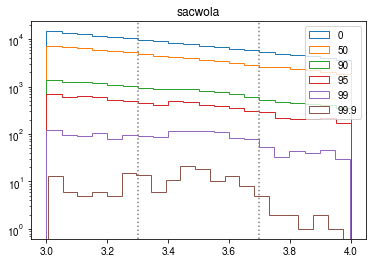

In [76]:
n_signal_test = n_signal*(test_frac/(1 - test_frac))
n_sel = x_data_test.shape[0] + x_sim_test.shape[0] + n_signal_test
y_sel_test = np.concatenate([np.ones(int(n_sel)), np.zeros(int(x_test.shape[0] - n_sel))]).astype(bool)

pvals = [0, 50, 90, 95, 99, 99.9]
window = (y_sr_test | y_sb_test) & y_sel_test
dtag = y_sim_test[window] == 1
stag = y_sim_test[window] == 0

for model_name,m in models.items():
    yhat_all = m.predict(x_test[window,1:])

    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct

        plt.hist(x_test[window,0][dtag][tag], histtype='step', label=p, density=0, bins=20)

    plt.gca().axvline(3.3, color='tab:grey', ls=':')
    plt.gca().axvline(3.7, color='tab:grey', ls=':')

    plt.title('{}'.format(model_name))
    plt.legend()
    plt.yscale('log')
    plt.show()

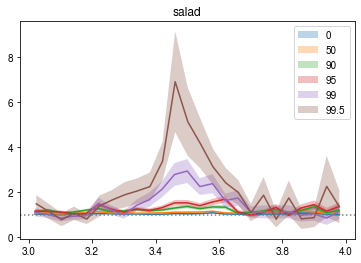

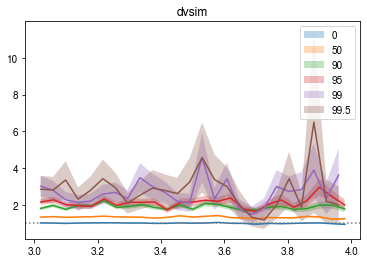

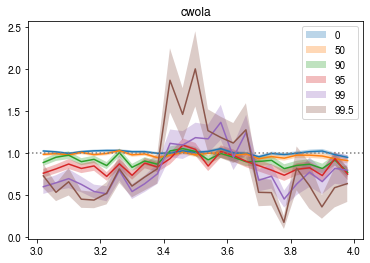

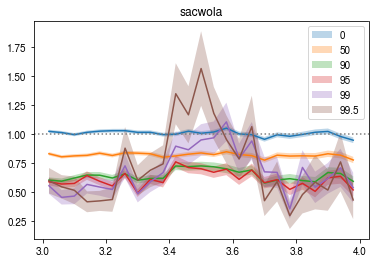

In [81]:
pvals = [0, 50, 90, 95, 99, 99.5]

for model_name,m in models.items():
    yhat_all = m.predict(x_test[window,1:])
    if hasattr(m, 'predict_weight'):
        w = m.predict_weight(x_test[window])
    else:
        w = np.ones_like(y_sim_test[window])
        
    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct
        tag_s = yhat_all[stag] >= pct

        dcnts,bns = np.histogram(x_test[window,0][dtag][tag], bins=25,)
        scnts,bns = np.histogram(x_test[window,0][stag][tag_s], weights=w[stag][tag_s], bins=25,)
        xpt = bns[:-1] + np.diff(bns)*.5

        val = (dcnts/scnts)
        err = val*np.sqrt(1/dcnts + 1/scnts)

        plt.plot(xpt, val)
        plt.fill_between(xpt, val - err, val + err, alpha=.3, label=p)

    plt.legend()
    plt.axhline(1, color='tab:grey', ls=':')
    plt.title(model_name)
    plt.show()

In [ ]:
w_sb = s.predict_weight(x_tr[sb])
plot_set(x_tr[sb], y_tr[sb], w_sb)

In [ ]:
w_sr = s.predict_weight(x_tr[sr])
plot_set(x_tr[sr], y_tr[sr], w_sr)

In [685]:
%run models.py